In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from constants import numeric_features, categorical_features
from sklearn.linear_model import LogisticRegression
from part2.shared import load_processed_data
from part2.shared import load_train_with_validation_data


In [2]:
NUMBER_OF_EPOCHS = 250

In [3]:

df = load_processed_data()
df = df[df["Target"].isin(["Graduate", "Dropout"])]
df["y"] = (df["Target"] == "Graduate").astype(int)
df = df.drop(columns=["Target", "Target encoded"], errors='ignore')

In [4]:
X = df.drop(columns=["y"])
y = df["y"].values

In [5]:
num_features = [c for c in numeric_features if c in X.columns]
cat_features = [c for c in categorical_features if c in X.columns]

In [6]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [7]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [8]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [9]:
X_train_raw, X_val_raw, X_test_raw, y_train, y_val, y_test = load_train_with_validation_data(X, y)
X_train = full_pipeline.fit_transform(X_train_raw)
X_test = full_pipeline.transform(X_test_raw)
X_val = full_pipeline.transform(X_val_raw)

In [10]:
X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train.toarray()])
X_test_bias = np.hstack([np.ones((X_test.shape[0], 1)), X_test.toarray()])
X_val_bias = np.hstack([np.ones((X_val.shape[0], 1)), X_val.toarray()])

In [11]:
from part3.Logistic import CustomLogisticRegression
models = {
    "no_reg": CustomLogisticRegression(lr=0.1, epochs=2000, batch_size=256, l1=0.0, l2=0.0, verbose=True),
    "l2_reg": CustomLogisticRegression(lr=0.1, epochs=2000, batch_size=256, l1=0.0, l2=0.001, verbose=True),
    "l1_reg": CustomLogisticRegression(lr=0.1, epochs=2000, batch_size=256, l1=0.001, l2=0.0, verbose=True),
}

X_train = full_pipeline.fit_transform(X_train_raw)
X_val = full_pipeline.transform(X_val_raw)
X_test = full_pipeline.transform(X_test_raw)


for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.fit(X_train, y_train, X_val, y_val, X_test, y_test)



Training model: no_reg
Epoch   1/2000  train_loss=0.4736  val_loss=0.4596
Epoch  20/2000  train_loss=0.2792  val_loss=0.2661
Epoch  40/2000  train_loss=0.2548  val_loss=0.2452
Epoch  60/2000  train_loss=0.2439  val_loss=0.2357
Epoch  80/2000  train_loss=0.2374  val_loss=0.2300
Epoch 100/2000  train_loss=0.2332  val_loss=0.2258
Epoch 120/2000  train_loss=0.2301  val_loss=0.2228
Epoch 140/2000  train_loss=0.2279  val_loss=0.2204
Epoch 160/2000  train_loss=0.2261  val_loss=0.2184
Epoch 180/2000  train_loss=0.2247  val_loss=0.2169
Epoch 200/2000  train_loss=0.2235  val_loss=0.2158
Epoch 220/2000  train_loss=0.2226  val_loss=0.2147
Epoch 240/2000  train_loss=0.2218  val_loss=0.2140
Epoch 260/2000  train_loss=0.2211  val_loss=0.2132
Epoch 280/2000  train_loss=0.2206  val_loss=0.2124
Epoch 300/2000  train_loss=0.2200  val_loss=0.2119
Epoch 320/2000  train_loss=0.2196  val_loss=0.2116
Epoch 340/2000  train_loss=0.2192  val_loss=0.2111
Epoch 360/2000  train_loss=0.2188  val_loss=0.2109
Epoch 3

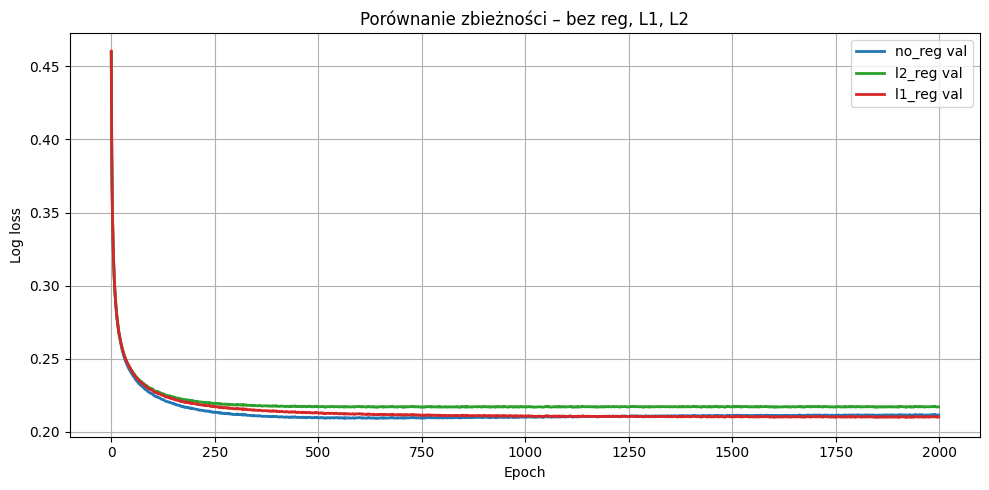

In [12]:
from matplotlib import pyplot as plt

colors = {
    "no_reg": "tab:blue",
    "l2_reg": "tab:green",
    "l1_reg": "tab:red"
}

plt.figure(figsize=(10, 5))

for name, model in models.items():
    plt.plot(model.history["val"], label=f"{name} val", color=colors[name], linewidth=2)

plt.title("Porównanie zbieżności – bez reg, L1, L2")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

comparison = {
    "Model": [],
    "Accuracy": [],
    "F1 (class 0)": [],
    "Recall (class 0)": []
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    comparison["Model"].append(name)
    comparison["Accuracy"].append(accuracy_score(y_test, y_pred))
    comparison["F1 (class 0)"].append(f1_score(y_test, y_pred, pos_label=0))
    comparison["Recall (class 0)"].append(recall_score(y_test, y_pred, pos_label=0))

import pandas as pd

df_comparison = pd.DataFrame(comparison)
print(df_comparison)


    Model  Accuracy  F1 (class 0)  Recall (class 0)
0  no_reg  0.910591      0.882033          0.855634
1  l2_reg  0.917469      0.890909          0.862676
2  l1_reg  0.921596      0.895795          0.862676


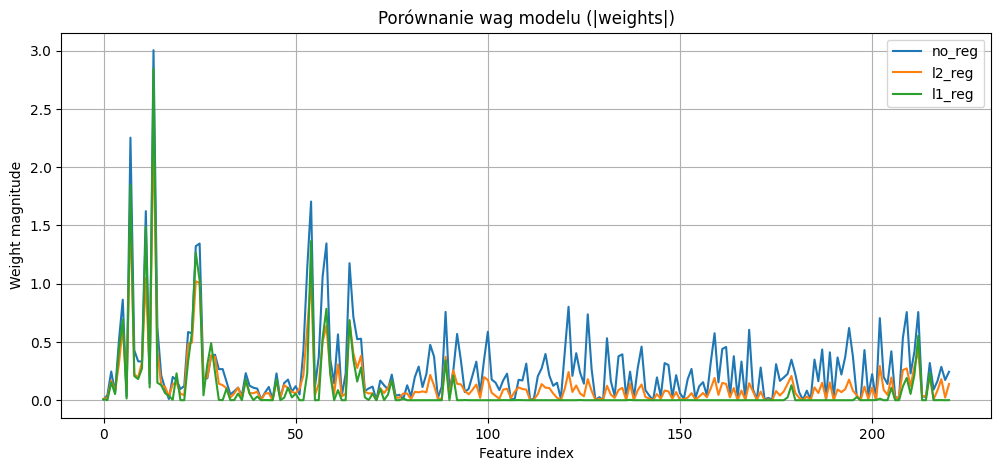

In [15]:
w_df = pd.DataFrame({
    "no_reg": models["no_reg"].w_,
    "l2_reg": models["l2_reg"].w_,
    "l1_reg": models["l1_reg"].w_,
})

# Wartości bezwzględne (łatwiej porównać)
w_df_abs = w_df.abs()
w_df_abs.plot(figsize=(12, 5), title="Porównanie wag modelu (|weights|)")
plt.xlabel("Feature index")
plt.ylabel("Weight magnitude")
plt.grid(True)
plt.show()
